# CS4168 Data Mining

## Data Mining Project - Steel Industry Energy Consumption

**Group 1:**
* Edison Cai (20241135)
* Sergiu Mereacre (20238029)
* Jack O'Brien (20245777)
* David Walsh (20276885)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from sklearn import svm, set_config, preprocessing, manifold, cluster
from sklearn.datasets import load_iris, make_blobs
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, silhouette_score, make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVR

In [ ]:
# Loading the dataset
df = pd.read_csv("./steel_industry_data_excerpt.csv")

# 1. Exploratory Data Analysis (EDA)

In [ ]:
# Let's first describe the dataset
df.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,28.438712,13.658685,3.959279,0.012027,80.943201,83.976822,43025.342466
std,34.055560,16.818180,7.512796,0.016445,18.751234,30.844623,24820.208535
min,2.480000,0.000000,0.000000,0.000000,40.710000,13.810000,0.000000
25%,3.240000,2.240000,0.000000,0.000000,64.125000,99.760000,21600.000000
50%,4.640000,5.040000,0.000000,0.000000,88.280000,100.000000,43200.000000
75%,52.780000,24.480000,2.200000,0.020000,99.087500,100.000000,64800.000000
max,145.300000,90.680000,27.360000,0.070000,100.000000,100.000000,85500.000000


In [ ]:
# Let's check if there are any missing values
df.isna().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
dtype: int64

In [ ]:
# Check if any of the values in the 'Usage_kWh' column are 0
any_zero_usage_kwh = (df['Usage_kWh'] == 0).any()
print(any_zero_usage_kwh)

False


* No empty values so the dataset is pretty clean and seems no empty usage entries.

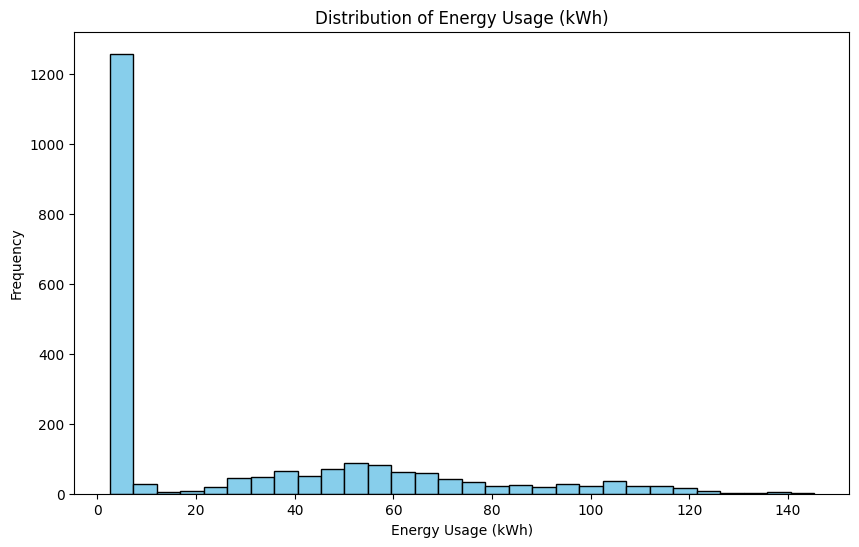

In [ ]:
# Histogram of Energy Usage
plt.figure(figsize=(10, 6))
plt.hist(df['Usage_kWh'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Energy Usage (kWh)')
plt.xlabel('Energy Usage (kWh)')
plt.ylabel('Frequency')
plt.show()

* A lot of the usage is very low from 0 to 10 of kWh it seems like.

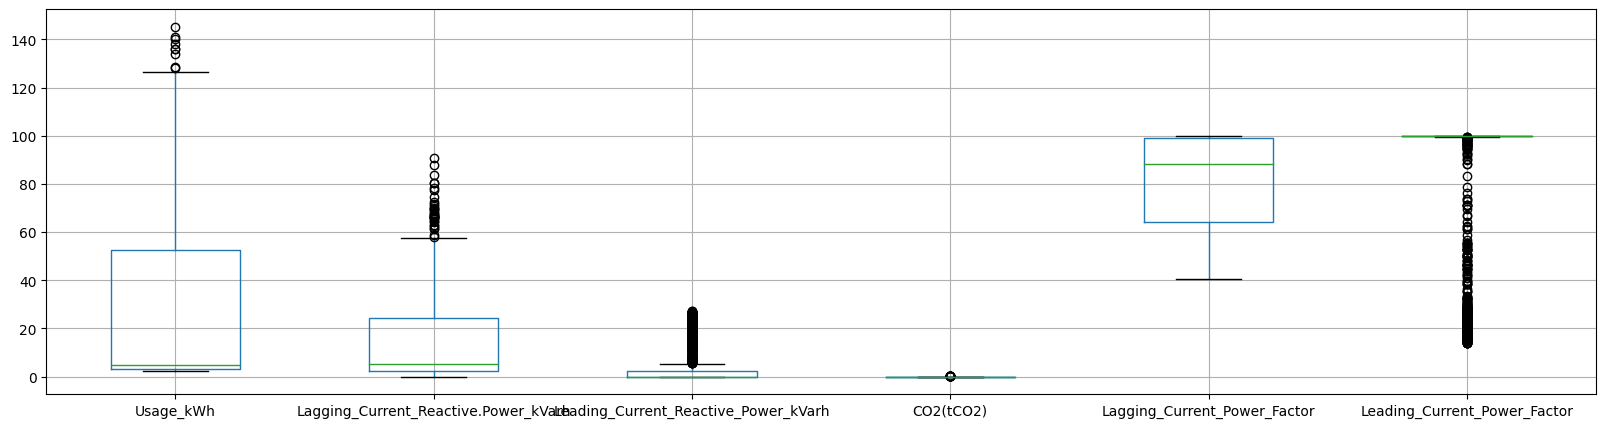

In [ ]:
# NSM has very large values so I will do boxplots till Leading Current Power Factor
df.loc[:,'Usage_kWh':'Leading_Current_Power_Factor'].boxplot(figsize=(20,5))
plt.show()

* The boxplot shows a number of points that lie beyond the upper bound of the boxplots for the Usage_kWh, Lagging_Current_Reactive.Power_kVarh, and Leading_Current_Reactive_Power_kVarh columns. These are potential outliers and may need to be investigated to determine if they are due to exceptional conditions or data recording errors.

* The leading_current_power_factor is very strange, I think its because the 25%tile is so low if you look at the describe function results above you'll noticed that the mean is very high so it just has some low outliers.

* There is a lot of stuff I think I will have to do in the data preparation phase.

I think the percent columns maybe shouln't be included since its in terms of percentage and not like other values. So i probably shouldn't look at outliers for them.

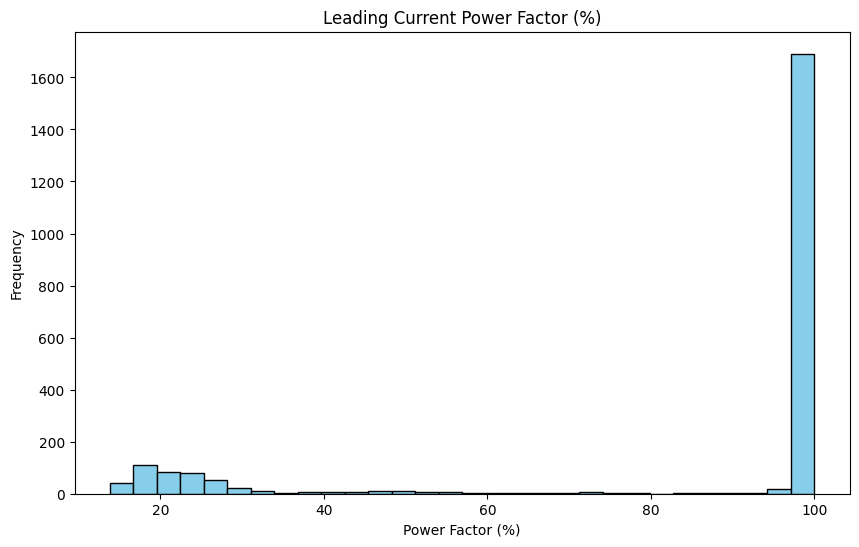

In [ ]:
# Histogram of Leading Current Power Factor
plt.figure(figsize=(10, 6))
plt.hist(df['Leading_Current_Power_Factor'], bins=30, color='skyblue', edgecolor='black')
plt.title('Leading Current Power Factor (%)')
plt.xlabel('Power Factor (%)')
plt.ylabel('Frequency')
plt.show()

* Majority of the power factor is very high. With some data between 0 to 30 it seems like.

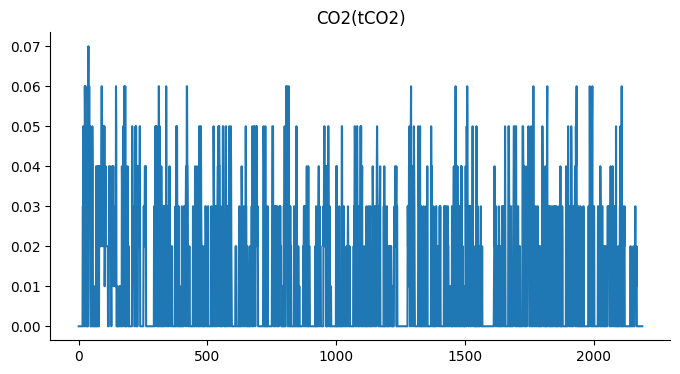

In [ ]:
# Plotting C02
from matplotlib import pyplot as plt
df['CO2(tCO2)'].plot(kind='line', figsize=(8, 4), title='CO2(tCO2)')
plt.gca().spines[['top', 'right']].set_visible(False)

* C02 emissions seem to be very constant between 0 to 0.07. Not much variance

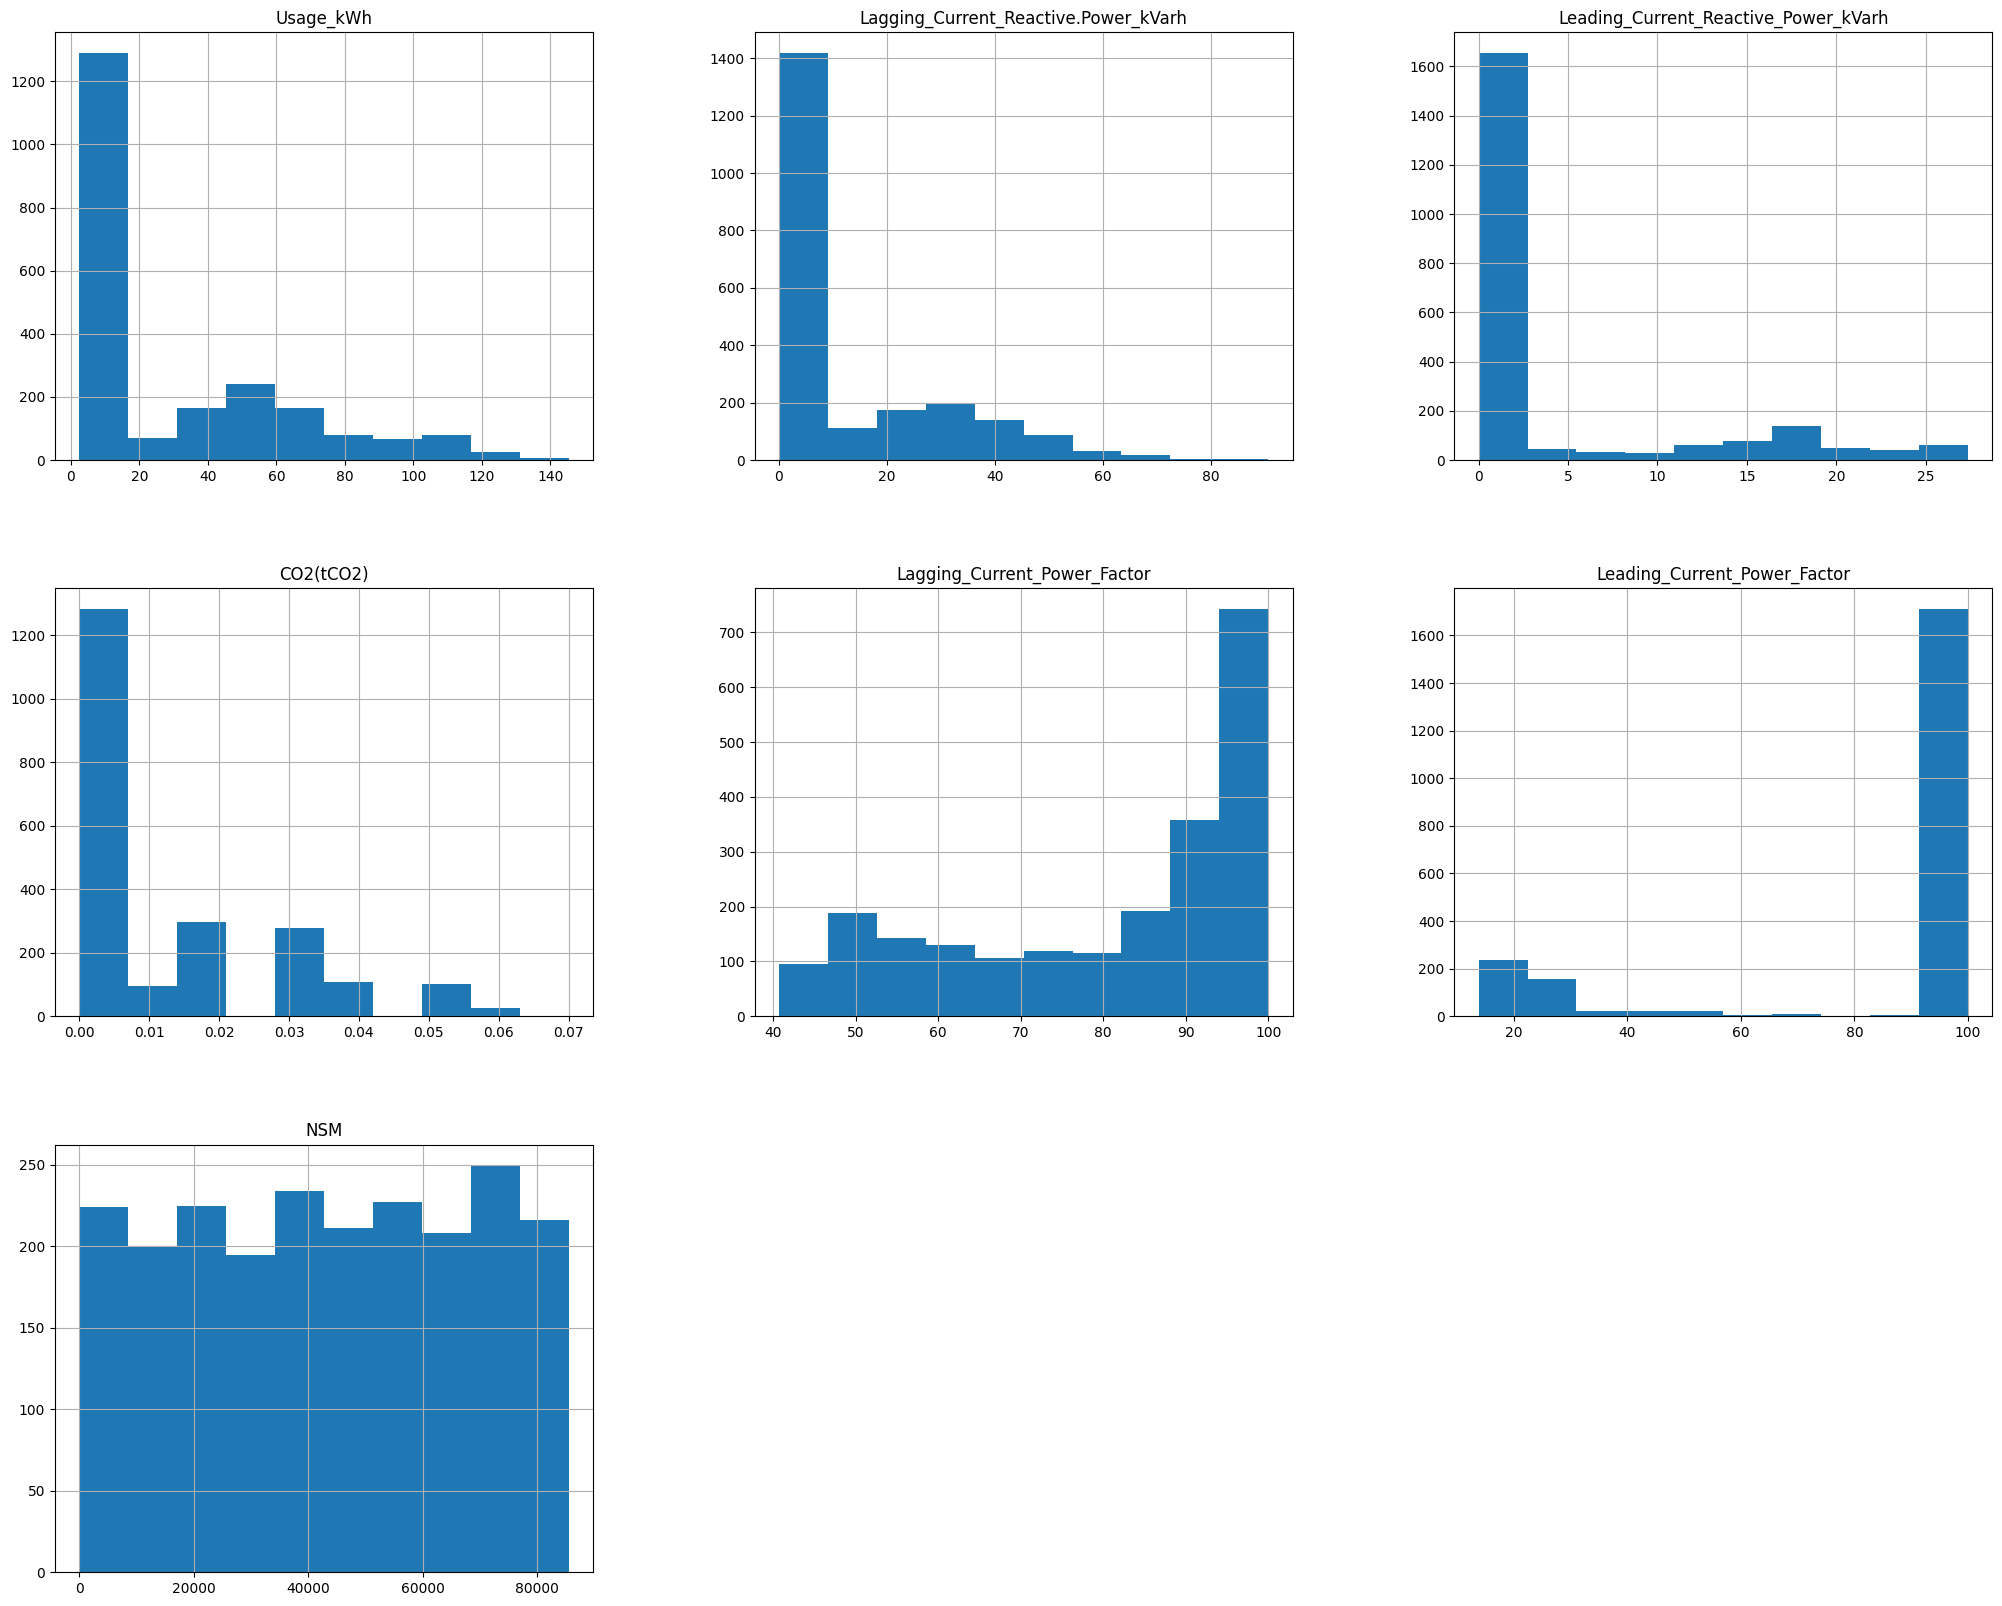

In [ ]:
# Let's look at the histogram of all attributes
df.hist(bins=10, figsize=(25, 20));

# 2. Data Preparation

In [ ]:
# Let's start preparing the dataset by one hot encoding and dropping the date column
data_dropped = df.drop('date', axis=1)

# One-hot encode 'WeekStatus' and 'Day_of_week'
data_encoded = pd.get_dummies(data_dropped, columns=['WeekStatus', 'Day_of_week'])

# Display the first few rows of the modified dataframe to verify the changes
data_encoded.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus_Weekday,WeekStatus_Weekend,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday
0,3.78,4.72,0.00,0.0,62.51,100.00,9000,True,False,False,True,False,False,False,False,False
1,3.28,3.82,0.00,0.0,65.14,100.00,15300,True,False,False,True,False,False,False,False,False
2,3.28,3.49,0.00,0.0,68.48,100.00,20700,True,False,False,True,False,False,False,False,False
3,3.64,0.00,16.88,0.0,100.00,21.08,36000,True,False,False,True,False,False,False,False,False
4,3.71,0.00,18.00,0.0,100.00,20.19,37800,True,False,False,True,False,False,False,False,False


In [ ]:
df.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,28.438712,13.658685,3.959279,0.012027,80.943201,83.976822,43025.342466
std,34.055560,16.818180,7.512796,0.016445,18.751234,30.844623,24820.208535
min,2.480000,0.000000,0.000000,0.000000,40.710000,13.810000,0.000000
25%,3.240000,2.240000,0.000000,0.000000,64.125000,99.760000,21600.000000
50%,4.640000,5.040000,0.000000,0.000000,88.280000,100.000000,43200.000000
75%,52.780000,24.480000,2.200000,0.020000,99.087500,100.000000,64800.000000
max,145.300000,90.680000,27.360000,0.070000,100.000000,100.000000,85500.000000


In [ ]:
# Define column groups with same data preparation
names_no_outliers = ['Lagging_Current_Power_Factor', 'CO2(tCO2)', 'Leading_Current_Power_Factor']
names_outliers_and_zeros = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh'];
names_outliers_no_zeros = ['NSM']

In [ ]:
outliers_no_zeros_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log1p)),
        ("scaler", RobustScaler())
    ]
)

outliers_and_zeros_pipeline = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt)),
        ("scaler", RobustScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("names_outliers_no_zeros", outliers_no_zeros_pipeline, names_outliers_no_zeros),
        ("names_outliers_and_zeros", outliers_and_zeros_pipeline, names_outliers_and_zeros),
        ("names_no_outliers", FunctionTransformer(np.cbrt), names_no_outliers)
    ],
    remainder="passthrough" # Note there are no remaining columns in this example
)

In [ ]:
# Create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

In [ ]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('names_outliers_no_zeros',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['NSM']),
                                                 ('names_outliers_and_zeros',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Lagging_Current_Reactive.Power_kVarh',
                                                   'Leading_Current_Reactive_Power_kVarh']),
                                                 ('names_no_outliers',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['Lagging_Current_Power_Factor',
                                                   'CO2(tCO2)',
                                                   'Leading_Current_Power_Factor'])])),
                ('svm', SVC(probability=True))])

In [ ]:
# Split the columns into target and predictors
y = data_encoded['Usage_kWh']
X = data_encoded.drop(['Usage_kWh'], axis=1)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Clustering

## 3.1 Loading the Dataset

In [ ]:
df = pd.read_csv("./steel_industry_data_excerpt.csv")
df = df.drop('date', axis=1)
df = pd.get_dummies(df, columns=['WeekStatus'],
                    dummy_na=True,
                        drop_first=True)
df = pd.get_dummies(df, columns=['Day_of_week'],
                    dummy_na=True,
                        drop_first=True)
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (2190, 16)


## 3.2 Scaling the Data

In [ ]:
# I can experiment with different kinds of scalers to get different insights into the clusters

min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

## 3.3 Scatterplot Function

In [ ]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

def clustering_scatterplot(points, labels, title):

    # Getting amount of clusters
    n_clusters = np.unique(labels).size

    # Rendering each cluster
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1],
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## 3.4 Custom Silhouette Score Function

In [ ]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)

   # Check the number of unique labels
    if len(set(labels)) < 2:
        # If less than 2 unique labels are found, return a default score
        return -1
    else:
        # Otherwise, compute the silhouette score
        score = silhouette_score(X, labels)
        return score

Defining pipelines for different clustering algorithms

In [ ]:
pipeline_dbscan = Pipeline([
    ('scaling', StandardScaler()),
    ('clustering', DBSCAN(eps=0.5))
])

pipeline_kmeans = Pipeline([
    ('scaling', StandardScaler()),
    ('clustering', KMeans(n_clusters=4, n_init='auto'))
])

pipeline_agglo = Pipeline([
    ('scaling', StandardScaler()),
    ('clustering', AgglomerativeClustering(n_clusters=4))
])

Defining clustering algorithm grid configs

In [ ]:
# Define the parameter grid for K-Means
param_grid_kmeans = {
    'clustering__n_clusters': [2, 3, 4, 5, 6]
}

# Define the parameter grid for Agglomerative Clustering
param_grid_agglo = {
    'clustering__n_clusters': [2, 3, 4, 5, 6]
}

param_grid_dbscan = {
    'clustering__eps': [0.5, 1.0, 1.5, 2.0],
    'clustering__min_samples': [5, 10, 15, 20]
}

grid_configs = [
    (GridSearchCV(pipeline_kmeans, param_grid_kmeans, cv=5), 'KMeans Clustering'),
    (GridSearchCV(pipeline_agglo, param_grid_agglo, cv=5, scoring=silhouette_scorer), 'Agglomerative Clustering'),
    (GridSearchCV(pipeline_dbscan, param_grid_dbscan, cv=5, scoring=silhouette_scorer), 'DBSCAN'),
]

In [ ]:
for grid_item in grid_configs:
  grid_item[0].fit(data)
  print(f"Best parameters for {grid_item[1]}: ", grid_item[0].best_params_)
  print(f"Best score for {grid_item[1]}: ", grid_item[0].best_score_)

Best parameters for KMeans Clustering:  {'clustering__n_clusters': 6}
Best score for KMeans Clustering:  -2933.6786694602124
Best parameters for Agglomerative Clustering:  {'clustering__n_clusters': 6}
Best score for Agglomerative Clustering:  0.3070167413390589
Best parameters for DBSCAN:  {'clustering__eps': 1.5, 'clustering__min_samples': 5}
Best score for DBSCAN:  0.5735247755629632


## 3.5 Fit and Show Clustering Function

In [ ]:
def show_clustering(grid_item, clustering_algorithm_name, manifold_name, XYcoordinates):

  labels = grid_item.best_estimator_.named_steps['clustering'].labels_


  clustering_scatterplot(points=XYcoordinates,
                        labels=labels,
                        title=f'{manifold_name} - {clustering_algorithm_name}')
  plt.show()

Iterating through different configs

In [ ]:
manifold_configs = [
    (manifold.MDS(n_components=2), 'MDS'),
    (manifold.TSNE(n_components=2), 'TSNE'),
    (manifold.Isomap(n_components=2), 'Isomap'),
    (manifold.SpectralEmbedding(n_components=2), 'Spectral Embedding'),
]

In [ ]:
transformed_datasets = []
for manifold, manifold_name in manifold_configs:
    XYcoordinates = manifold.fit_transform(data)
    transformed_datasets.append((XYcoordinates, manifold_name))

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 17 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/loc

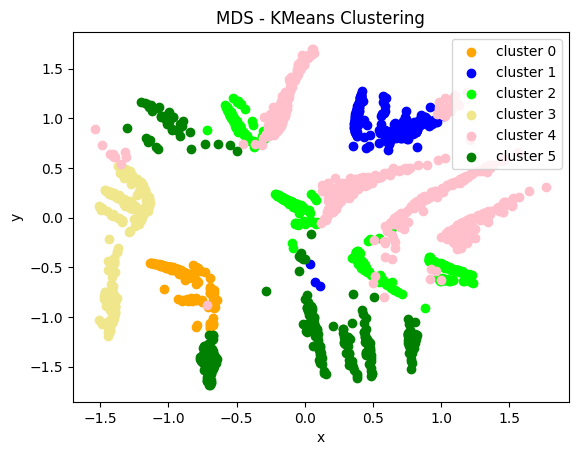

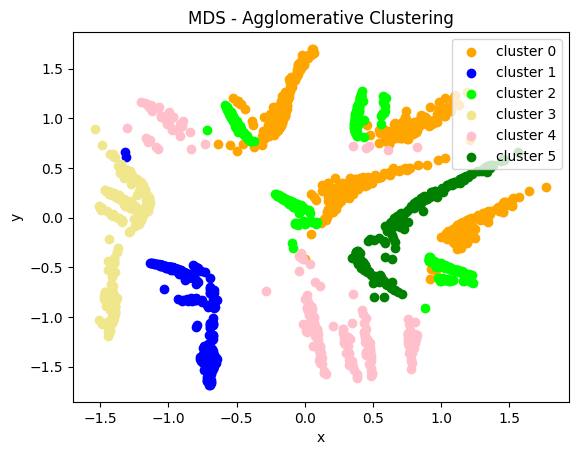

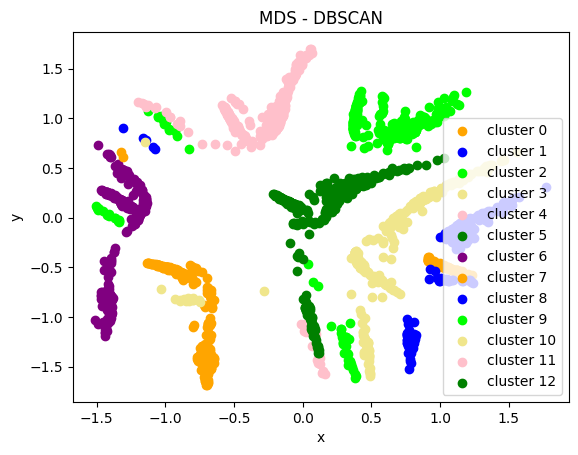

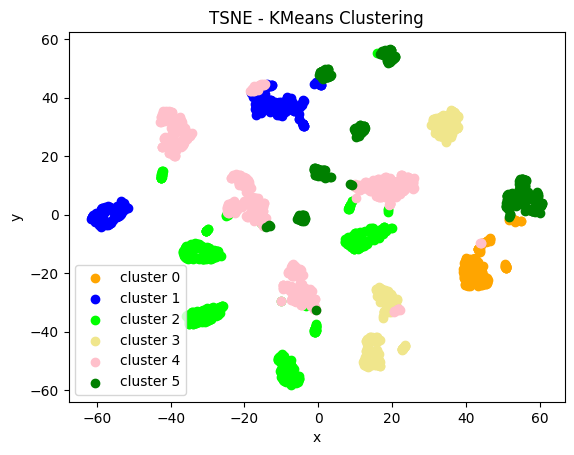

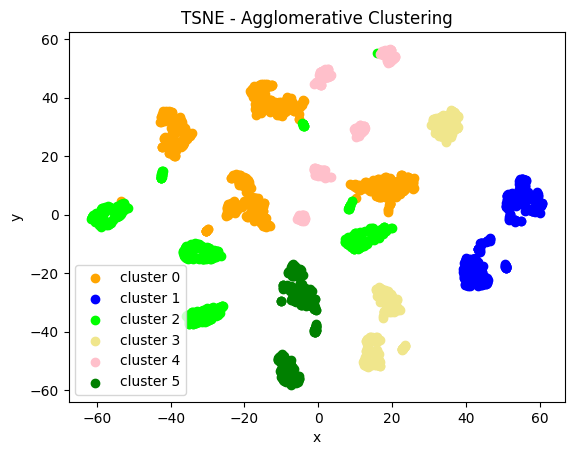

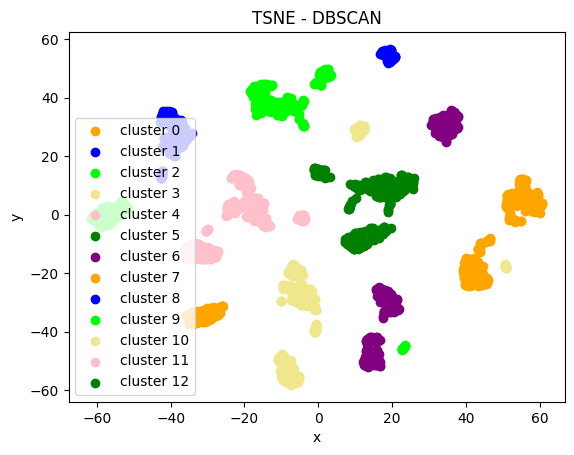

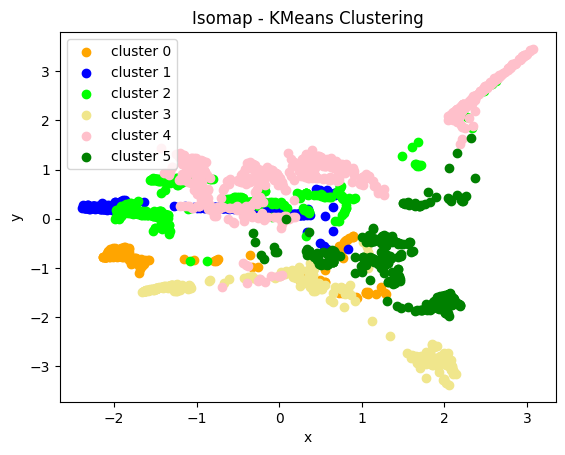

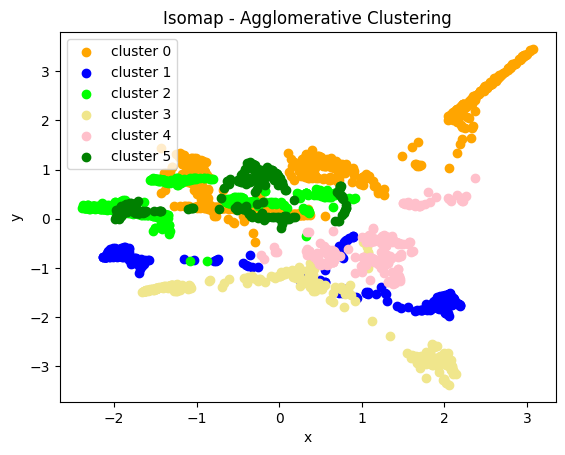

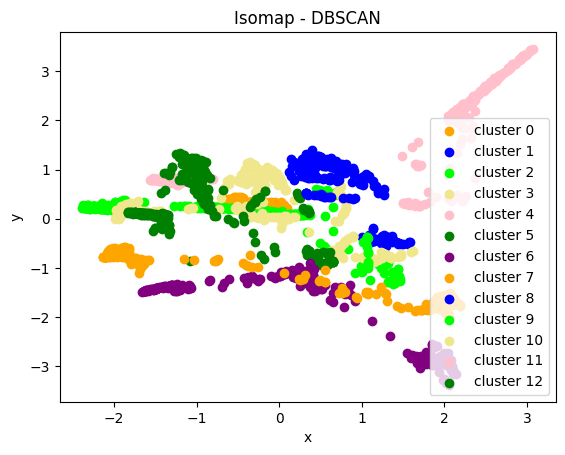

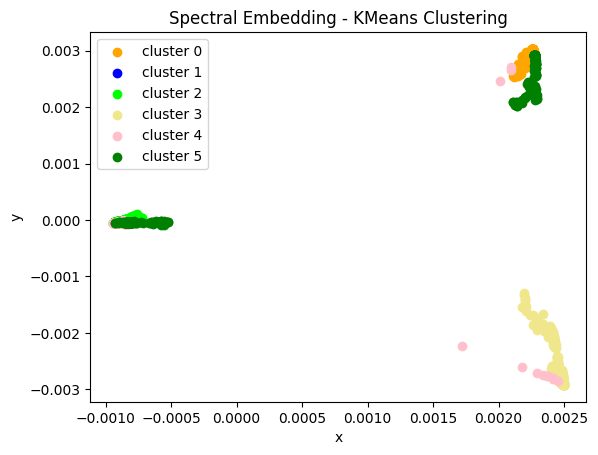

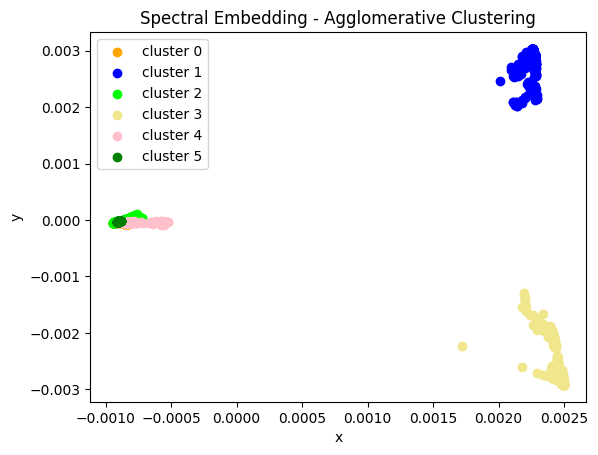

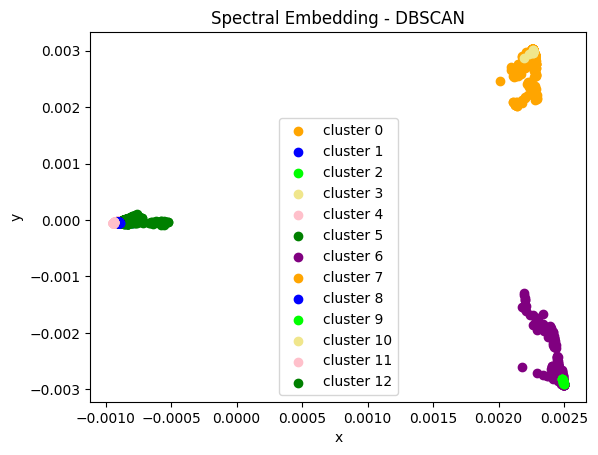

In [ ]:
for XYcoordinates, manifold_name in transformed_datasets:
    for grid_config, clustering_algorithm_name in grid_configs:
        show_clustering(grid_config, clustering_algorithm_name, manifold_name, XYcoordinates)

## 3.6 Cluster Visualisation

The visualisation of the clusters formed by different combinations of dimensionality reduction techniques and optimum clustering algorithm configurations provide some insights into possible underlying patterns in the dataset.

- MDS
  - Although the clusters were not well defined with KMeans, combining MDS with agglomerative clustering and DBSCAN result in slightly more defined clusters.
- t-SNE
  - Similarly, t-SNE also worked better with agglo and DBSCAN over KMeans when it comes to revealing well-defined clusters.
- Isomap
  - There is a lack of clear clusters which suggest that Isomap might not be the best method for visualising patterns in this particular dataset.
- Spectral Embedding
  - Combining spectral embedding with agglo produced the most defined clusters.

Some combinations, like t-SNE with DBSCAN, appear to be more effective at revealing patterns in the data while others like Isomap seem less effective. Since t-SNE with DBSCAN produced more defined clusters, this suggests that the data has a complex, non-linear structure (t-SNE handles non-linear data well) and has dense regions of points. (DBSCAN is good at finding clusters of similar density)

## 3.7 Cluster Analysis

In [ ]:
# Analysing cluster info based on DBSCAN, the third estimator
df['cluster'] = pd.Series(grid_configs[2][0].best_estimator_.named_steps['clustering'].labels_, index=df.index)

In [ ]:
df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus_Weekend,WeekStatus_nan,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Day_of_week_nan,cluster
0,3.78,4.72,0.00,0.0,62.51,100.00,9000,False,False,True,False,False,False,False,False,False,0
1,3.28,3.82,0.00,0.0,65.14,100.00,15300,False,False,True,False,False,False,False,False,False,0
2,3.28,3.49,0.00,0.0,68.48,100.00,20700,False,False,True,False,False,False,False,False,False,0
3,3.64,0.00,16.88,0.0,100.00,21.08,36000,False,False,True,False,False,False,False,False,False,1
4,3.71,0.00,18.00,0.0,100.00,20.19,37800,False,False,True,False,False,False,False,False,False,1


In [ ]:
df.tail()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus_Weekend,WeekStatus_nan,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Day_of_week_nan,cluster
2185,3.02,2.12,0.11,0.0,81.85,99.93,24300,False,False,True,False,False,False,False,False,False,0
2186,3.17,0.00,14.65,0.0,100.00,21.15,35100,False,False,True,False,False,False,False,False,False,1
2187,3.31,0.00,13.68,0.0,100.00,23.52,49500,False,False,True,False,False,False,False,False,False,1
2188,4.14,0.00,20.09,0.0,100.00,20.18,72000,False,False,True,False,False,False,False,False,False,1
2189,3.82,4.54,0.00,0.0,64.38,100.00,81900,False,False,True,False,False,False,False,False,False,8


In [ ]:
df.groupby('cluster').mean()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus_Weekend,WeekStatus_nan,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Day_of_week_nan
cluster,,,,,,,,,,,,,,,,
-1,50.887778,30.891111,2.587778,0.018889,93.287778,74.207778,31000.000000,0.222222,0.0,0.222222,0.222222,0.0,0.111111,0.111111,0.0,0.0
0,3.447347,4.413469,0.007449,0.000000,61.055102,99.996735,15244.897959,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,4.712800,0.119400,18.251000,0.000000,99.593000,25.224000,60318.000000,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
2,35.320982,17.017454,2.871319,0.015307,80.504202,89.523160,43139.263804,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0
3,32.724377,16.787374,2.624680,0.014242,79.515825,89.540673,42706.060606,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.0
4,39.916316,19.474803,2.504836,0.017434,81.010822,92.283882,40585.855263,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0
5,32.870606,15.254182,2.825152,0.014091,80.278909,90.221848,44015.454545,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
6,17.700601,6.653958,6.703074,0.007173,84.841307,72.230495,41129.681979,1.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0
7,7.392318,3.293183,8.241765,0.001938,82.887855,61.398754,39410.034602,1.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0


## 3.8 Conclusion
By looking at the table above we can observe that:

- Cluster 0: This cluster has low energy usage and CO2 emissions, it has the lowest average NSM. Its activities are concentrated on Mondays.

- Cluster 1: This cluster also has low energy usage and CO2 emissions. It has the highest average lagging current power factor and leading current reactive power, but the lowest leading current power factor. Its activities are also concentrated on Mondays.

- Cluster 8: This cluster has the highest average energy usage with one of the highest lagging current reactive power values and CO2 emissions. Its activities are concentrated on Mondays.

- Cluster 9: This cluster has low energy usage, CO2 emissions, and leading current reactive power. Its activities occur during the weekend - Saturdays in particular.

- Cluster 10: Similar to Cluster 9, this cluster also has low energy usage and CO2 emissions. It has a high average NSM, and its activities occur during the weekend, but on Sundays instead of Saturdays.

- Cluster 11: This cluster has the lowest average lagging current power factor. It also has low energy usage and CO2 emissions. Its activities are concentrated on Thursdays.

We can also make some observations for potential connections between Usage_kWh and other attributes.

1. Lagging_Current_Reactive.Power_kVarh: These two features seem to have a relationship with Usage_kWh. Clusters with higher average energy usage (like cluster 8) also have higher average lagging reactive power. Conversely, clusters with lower average energy usage (like clusters 0, 1, 9, 10, and 11) have lower average lagging current reactive power.

2. CO2(tCO2): This feature also appears to be related to Usage_kWh. Clusters with higher average energy usage (especially cluster 8) tend to have higher average CO2 emissions, and vice versa.

3. NSM: This feature does not appear to have a clear relationship with Usage_kWh. Clusters with both high and low average energy usage have a wide range of average NSM values.

4. WeekStatus_Weekend and Day_of_week: These features do not appear to have a clear relationship with Usage_kWh. Clusters with both high and low average energy usage have activities on different days of the week.

The conclusions made are true for this run of dbscan. If the code is executed again, dbscan may produce either different clusters or the same clusters but in a different order.

# 4. Regression

## 4.1 Random Forest Regression

In [ ]:
rf_pipe = Pipeline(steps = [('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor = RandomForestRegressor(n_estimators = 10),
                           func = np.log,
                           inverse_func = np.exp)
                       )
                      ]
               )

In [ ]:
RF_N_FEATURES_OPTIONS = [2, 6, 8]
RF_MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
RF_C_OPTIONS = [0.1, 1, 10]

rf_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power = 7), TruncatedSVD(), FastICA()],
        'reduce_dim__n_components': RF_N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': RF_MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel = 'linear', gamma = 'auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': RF_N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': RF_MAX_DEPTH_OPTIONS
    },
]

rf_search = GridSearchCV(rf_pipe, rf_param_grid, n_jobs = -1, cv = 5, refit = True)
rf_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % rf_search.best_score_)
print("Best parameters: ", rf_search.best_params_)

# Store the best params and best model for later use
rf_best_params = rf_search.best_params_
rf_best_model = rf_search.best_estimator_

Best CV score = 0.993:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__max_depth': 8}


## 4.2 Linear Regression

In [ ]:
lr_pipe = Pipeline(steps = [('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor = LinearRegression(),
                           func = np.log,
                           inverse_func = np.exp)
                       )
                      ]
               )

In [ ]:
LR_N_FEATURES_OPTIONS = [2, 6, 8]
LR_FIT_INTERCEPT_OPTIONS = [False, True]

lr_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power = 7), TruncatedSVD(), FastICA()],
        'reduce_dim__n_components': LR_N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': LR_FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel = 'linear', gamma = 'auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': LR_N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': LR_FIT_INTERCEPT_OPTIONS
    } ,
]

lr_search = GridSearchCV(lr_pipe, lr_param_grid, n_jobs = -1, cv = 5, refit = True)
lr_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % lr_search.best_score_)
print("Best parameters: ", lr_search.best_params_)

# store the best params and best model for later use
lr_best_params = lr_search.best_params_
lr_best_model = lr_search.best_estimator_

Best CV score = 0.984:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=2), 'reduce_dim__n_features_to_select': 2, 'ttr__regressor__fit_intercept': True}


## 4.3 Support Vector Regression (SVR)

In [ ]:
svr_pipe = Pipeline(steps = [('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor = SVR(),
                           func = np.log,
                           inverse_func = np.exp)
                       )
                      ]
               )

In [ ]:
SVR_N_FEATURES_OPTIONS = [2, 6, 8]
SVR_C_OPTIONS = [0.1, 1, 10] # Penalty for misclassification. Larger C means smaller margins
SVR_EPSILON_OPTIONS = [0.1, 0.01, 0.001] # Defines width of epsilon-tube. Smaller epsilon values make the model more sensitive to errors.
SVR_KERNEL_OPTIONS = ['linear', 'rbf', 'poly'] # Kernel functions to be used in the algorithm

svr_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power = 7), TruncatedSVD(), FastICA()],
        'reduce_dim__n_components': SVR_N_FEATURES_OPTIONS,
        'ttr__regressor__C': SVR_C_OPTIONS,
        'ttr__regressor__epsilon': SVR_EPSILON_OPTIONS,
        'ttr__regressor__kernel': SVR_KERNEL_OPTIONS,
    },
    {
        'reduce_dim': [RFE(SVR(kernel = 'linear')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': SVR_N_FEATURES_OPTIONS,
        'ttr__regressor__C': SVR_C_OPTIONS,
        'ttr__regressor__epsilon': SVR_EPSILON_OPTIONS,
        'ttr__regressor__kernel': SVR_KERNEL_OPTIONS,
    },
]

svr_search = GridSearchCV(svr_pipe, svr_param_grid, n_jobs = -1, cv = 5, refit = True)
svr_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % svr_search.best_score_)
print("Best parameters: ", svr_search.best_params_)

# Store the best params and best model for later use
svr_best_params = svr_search.best_params_
svr_best_model = svr_search.best_estimator_

Best CV score = 0.988:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__C': 10, 'ttr__regressor__epsilon': 0.1, 'ttr__regressor__kernel': 'poly'}


## 4.4 Gradient Boosting Regression

In [ ]:
# Define a pipeline for Gradient Boosting Regressor
gb_pipe = Pipeline(steps = [('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor = GradientBoostingRegressor(),
                           func = np.log,
                           inverse_func = np.exp)
                       )
                      ]
               )

In [ ]:
# Options for Gradient Boosting Regressor
GB_N_FEATURES_OPTIONS = [2, 6, 8]
GB_LEARNING_RATE_OPTIONS = [0.01, 0.1, 0.2]  # Learning rate shrinks the contribution of each tree
GB_N_ESTIMATORS_OPTIONS = [50, 100, 200]  # Number of boosting stages to perform
GB_MAX_DEPTH_OPTIONS = [3, 5, 7]  # Maximum depth of the individual regression estimators

# Define the parameter grid for Gradient Boosting Regressor
gb_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), TruncatedSVD(), FastICA()],
        'reduce_dim__n_components': GB_N_FEATURES_OPTIONS,
        'ttr__regressor__learning_rate': GB_LEARNING_RATE_OPTIONS,
        'ttr__regressor__n_estimators': GB_N_ESTIMATORS_OPTIONS,
        'ttr__regressor__max_depth': GB_MAX_DEPTH_OPTIONS,
    },
    {
        'reduce_dim': [RFE(LinearRegression()), RFE(GradientBoostingRegressor())],
        'reduce_dim__n_features_to_select': GB_N_FEATURES_OPTIONS,
        'ttr__regressor__learning_rate': GB_LEARNING_RATE_OPTIONS,
        'ttr__regressor__n_estimators': GB_N_ESTIMATORS_OPTIONS,
        'ttr__regressor__max_depth': GB_MAX_DEPTH_OPTIONS,
    },
]

# Create and fit the GridSearchCV
gb_search = GridSearchCV(gb_pipe, gb_param_grid, n_jobs = -1, cv = 5, refit = True)
gb_search.fit(X_train, y_train)

# Print the best cross-validation score and the best parameters
print("Best CV score = %0.3f:" % gb_search.best_score_)
print("Best parameters: ", gb_search.best_params_)

# Store the best parameters and best model for later use
gb_best_params = gb_search.best_params_
gb_best_model = gb_search.best_estimator_

Best CV score = 0.995:
Best parameters:  {'reduce_dim': RFE(estimator=GradientBoostingRegressor(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__learning_rate': 0.2, 'ttr__regressor__max_depth': 5, 'ttr__regressor__n_estimators': 200}


## 4.5 Evaluation

In [ ]:
# A trained regression model

def evaluate_model(X_test, y_test, model):
    _predicted_values = model.predict(X_test) # Compute predictions for the test set

    # Compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)

    return _mse, _mae, _r2

In [ ]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, rf_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, lr_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, svr_best_model)
GB_mse, GB_mae, GB_r2 = evaluate_model(X_test, y_test, gb_best_model)

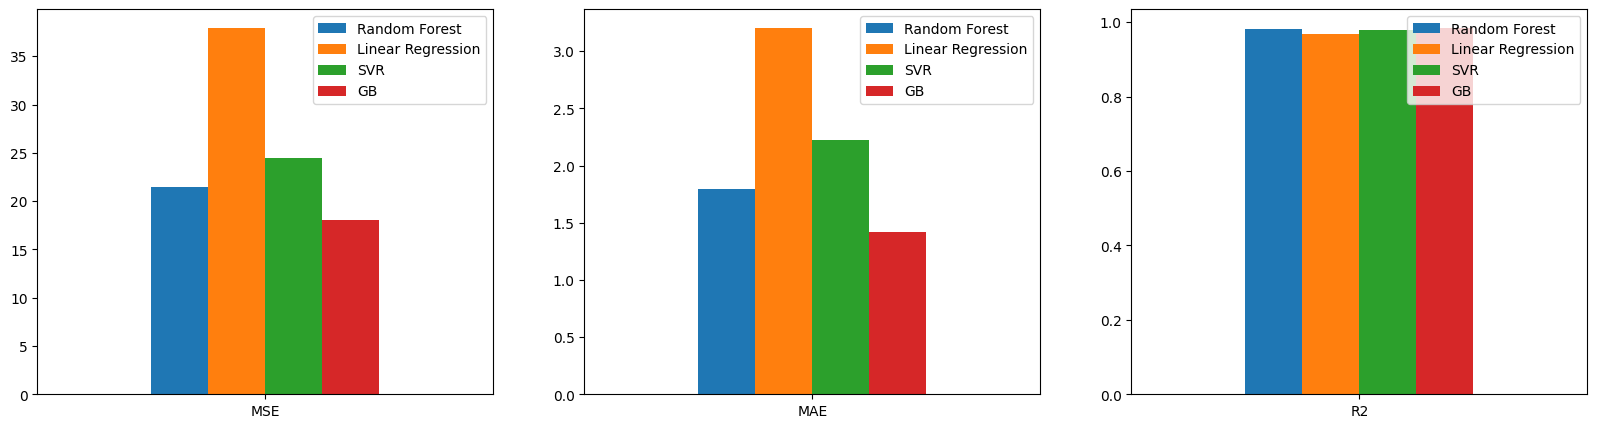

In [ ]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SVR': SVR_mse, 'GB': GB_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SVR': SVR_mae, 'GB': GB_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SVR': SVR_r2, 'GB': GB_r2}, index=['R2'])

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

df_mse.plot.bar(rot = 0, ax = axes[0])
df_mae.plot.bar(rot = 0, ax = axes[1])
df_r2.plot.bar(rot = 0, ax = axes[2])

plt.show()

From the results:
- The Gradient Boosting (GB) model has the lowest MSE, suggesting it has the least average squared errors among the predictions.
- The GB model also has the lowest MAE, indicating it generally has smaller prediction errors than the other models.
- The Random Forest, SVR, and GB models have the highest R2 score (although all of the models are extremely close), suggesting they can explain a higher proportion of the variance in the data.

Considering all three metrics, the GB model is the best-performing one among those tested. It fits the data more closely (low MSE and MAE) and provides the most reliable predictions regarding variance explanation (high R2). The Gradient Boosting model would be the best choice for predicting the 'Usage_kWh' attribute.

Note: Further validation, such as checking for overfitting through additional test sets or applying cross-validation, should be considered to confirm these results more robustly.

# 5. Classification

In [ ]:
# Calculate the mean of 'Usage_kWh'
mean_usage_kwh = df['Usage_kWh'].mean()

# Create the 'Usage_kWh_categorical' column
df['Usage_kWh_categorical'] = ['Low' if x <= mean_usage_kwh else 'High' for x in df['Usage_kWh']]

# Show the updated DataFrame
print(df.head())

   Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0       3.78                                  4.72   
1       3.28                                  3.82   
2       3.28                                  3.49   
3       3.64                                  0.00   
4       3.71                                  0.00   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00        0.0   
1                                  0.00        0.0   
2                                  0.00        0.0   
3                                 16.88        0.0   
4                                 18.00        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor    NSM  \
0                         62.51                        100.00   9000   
1                         65.14                        100.00  15300   
2                         68.48                        100.00  20700   
3                        100.00                         21.08 

In [ ]:
# Check for both 'Low' and 'High' values
# df[df['Usage_kWh_categorical'] == 'High'].head(1).append(df[df['Usage_kWh_categorical'] == 'Low'].head(1))

#df[df['Usage_kWh_categorical'] == 'High'].head(1).append(df[df['Usage_kWh_categorical'] == 'Low'].head(1))
result_df = pd.concat([df[df['Usage_kWh_categorical'] == 'High'].head(1), df[df['Usage_kWh_categorical'] == 'Low'].head(1)])

In [ ]:
# Dropping the 'date' column and preparing features and target variable
# X = df.drop(['date', 'Usage_kWh', 'Usage_kWh_categorical'], axis=1)
X = df.drop(['Usage_kWh', 'Usage_kWh_categorical'], axis=1)
y = df['Usage_kWh_categorical']

# Identifying numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Creating transformers for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Creating the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter grids for grid search
param_grid = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'Random Forest': {
        'classifier__n_estimators': [10, 50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    }
}

# Classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

best_scores = {}

# Loop for grid search on each classifier
for name, classifier in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])
    grid_search = GridSearchCV(pipeline, param_grid=param_grid[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_scores[name] = {
        'Best Parameters': grid_search.best_params_,
        'Best Accuracy': grid_search.best_score_
    }

for name, score_info in best_scores.items():
    print(f"{name} - Best Accuracy: {score_info['Best Accuracy']}, Best Parameters: {score_info['Best Parameters']}")


Logistic Regression - Best Accuracy: 0.9920081400081401, Best Parameters: {'classifier__C': 100, 'classifier__solver': 'lbfgs'}
Random Forest - Best Accuracy: 0.9925795685795686, Best Parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 10}
Gradient Boosting - Best Accuracy: 0.9914383394383395, Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}


The best accuracies were :
*   Random Forest: Best Accuracy = 99.26%, with max_depth=10 and n_estimators=50.
*   Logistic Regression: Best Accuracy = 99.2%, with C=0.1 and solver='liblinear'.
*    
Gradient Boosting: Best Accuracy = 99.14%, with learning_rate=0.01, max_depth=3, and n_estimators=50.

Random Forest model shows higher accuracy than the other models.It did this  with a small tree depth (max_depth=10) and (n_estimators=50), theres is a balance between performance and computation.(accuracy and speed)

The Random Forest model's can handle complex data without overfitting, so it is the best choice for this task. Its can generalize unseen data, making it perfect for predicting the 'Usage_kWh_categorical' target variable in the dataset.







